In [1]:
pip install -U "transformers>=4.48.0" "peft>=0.14.0" "accelerate>=1.1.0" "bitsandbytes>=0.45.0" "datasets"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 113.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 41.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 80.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8

# 1. Library

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [14]:
import os
import torch
import numpy as np
import json
import pandas as pd

import warnings
from pydantic import PydanticDeprecatedSince20
warnings.filterwarnings("ignore", category=UserWarning)

from datasets import load_dataset, DatasetDict
from transformers.trainer_utils import get_last_checkpoint
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from pathlib import Path
from tqdm.auto import tqdm

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback,
    TrainerCallback,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)

# 2. Load dataset

In [4]:
ds = load_dataset("lndat18/vi-alpaca_small_augmented_data")

README.md:   0%|          | 0.00/611 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/6.81M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/847k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/857k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15200 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1900 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1900 [00:00<?, ? examples/s]

In [5]:
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

# 3. Load model & tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct", use_fast=True)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-1.5B-Instruct", 
    quantization_config=bnb_config,
    device_map="auto",
)

model.config.use_cache = False
model.gradient_checkpointing_enable()

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
)

model = get_peft_model(model, lora_config)
model.enable_input_require_grads()


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [7]:
messages = [
    {"role": "user", "content": "Who are you?"},
]

inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=40)
print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))


I am Qwen, an AI assistant created by Alibaba Cloud. I'm here to help with questions and provide information on various topics. How can I assist you today?<|im_end|>


# 4. Tokenize train/val/test

In [8]:
MAX_LEN = 256

def tokenize_for_training(batch):
    texts = []
    for msgs in batch["messages"]:
        text = tokenizer.apply_chat_template(
            msgs,
            tokenize=False,
            add_generation_prompt=False,   # mình đã có assistant reply trong messages
        )
        texts.append(text)

    enc = tokenizer(
        texts,
        max_length=MAX_LEN,
        truncation=True,
        padding=False,
    )

    enc["labels"] = enc["input_ids"].copy()
    return enc

train_tok = train_ds.map(
    tokenize_for_training,
    batched=True,
    remove_columns=train_ds.column_names,
    desc="Tokenize train",
)

val_tok = val_ds.map(
    tokenize_for_training,
    batched=True,
    remove_columns=val_ds.column_names,
    desc="Tokenize val",
)

test_tok = test_ds.map(
    tokenize_for_training,
    batched=True,
    remove_columns=test_ds.column_names,
    desc="Tokenize test",
)


Tokenize train:   0%|          | 0/15200 [00:00<?, ? examples/s]

Tokenize val:   0%|          | 0/1900 [00:00<?, ? examples/s]

Tokenize test:   0%|          | 0/1900 [00:00<?, ? examples/s]

# 5. Data collator

In [9]:
# DataCollator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,   # causal LM
)


# 6. Early Stoping

In [10]:
# EarlyStoping

class MyEarlyStoppingCallback(EarlyStoppingCallback):
    def on_train_end(self, args, state, control, **kwargs):
        # Chỉ in ở process chính (tránh in lặp lại trong multi-GPU)
        if state.is_world_process_zero:
            print("✅ Training dừng sớm bởi EarlyStoppingCallback")
            print(f"  - Global step: {state.global_step}")
            print(f"  - Best metric: {state.best_metric}")
            print(f"  - Best model checkpoint: {state.best_model_checkpoint}")
        # Gọi lại hàm gốc để không phá logic early stopping
        return super().on_train_end(args, state, control, **kwargs)


# 7. Training

In [11]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/qwen25-1_5b-vi-alpaca-small",
    num_train_epochs=5,                # thử 1 epoch trước, sau đó tăng lên 2–3 nếu ổn
    per_device_train_batch_size=1,     # full finetune -> để 1 cho chắc
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,     # 1*8 = effective batch 8
    learning_rate=5e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,

    optim="paged_adamw_8bit",
    load_best_model_at_end=True,     # sau khi train xong, load lại model tốt nhất
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    fp16=True,                         # Kaggle dùng fp16
    bf16=False,

    logging_steps=200,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    report_to="none",                  # tắt WandB nếu không dùng

    label_names=["labels"],
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    callbacks=[
        MyEarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.036, 
        )
    ],
)

In [12]:
output_dir = training_args.output_dir
last_ckpt = get_last_checkpoint(output_dir)

if last_ckpt is not None:
    print(f"Found last checkpoint: {last_ckpt}")

    # Đọc trạng thái trainer từ checkpoint
    state_path = os.path.join(last_ckpt, "trainer_state.json")
    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)

    last_epoch = state.get("epoch", None)
    global_step = state.get("global_step", None)

    print(f"Lần trước dừng ở epoch: {last_epoch}")
    print(f"Global step: {global_step}")

    # Tiếp tục train từ checkpoint này
    print("Trainer device:", trainer.args.device)
    trainer.train(resume_from_checkpoint=last_ckpt)
    
else:
    print("Không tìm thấy checkpoint, train từ đầu.")
    print("Trainer device:", trainer.args.device)
    trainer.train()



Found last checkpoint: /kaggle/working/qwen25-1_5b-vi-alpaca-small/checkpoint-5700
Lần trước dừng ở epoch: 3.0
Global step: 5700
Trainer device: cuda:0


Epoch,Training Loss,Validation Loss
4,0.567800,1.033945
5,0.417900,1.142890


✅ Training dừng sớm bởi EarlyStoppingCallback
  - Global step: 9500
  - Best metric: 0.9479589462280273
  - Best model checkpoint: /kaggle/working/qwen25-1_5b-vi-alpaca-small/checkpoint-3800


In [13]:
output_dir = training_args.output_dir
last_ckpt = Path(get_last_checkpoint(output_dir))
state_path = last_ckpt / "trainer_state.json"
    
# 1) Đọc trainer_state.json
with open(state_path, "r", encoding="utf-8") as f:
    state = json.load(f)


# 2) Lấy log_history -> DataFrame
logs = state["log_history"]          # list[dict]
df_logs = pd.DataFrame(logs)


# 3) Lọc các dòng có eval_loss (mỗi epoch 1 dòng)
df_eval = df_logs[df_logs["eval_loss"].notna()][["epoch", "eval_loss", "eval_runtime"]]
df_eval = df_eval.reset_index(drop=True)

print(df_eval)

   epoch  eval_loss  eval_runtime
0    1.0   0.994713      323.1447
1    2.0   0.947959      318.7199
2    3.0   0.993496      321.4084
3    4.0   1.033945      318.6666
4    5.0   1.142890      321.3629


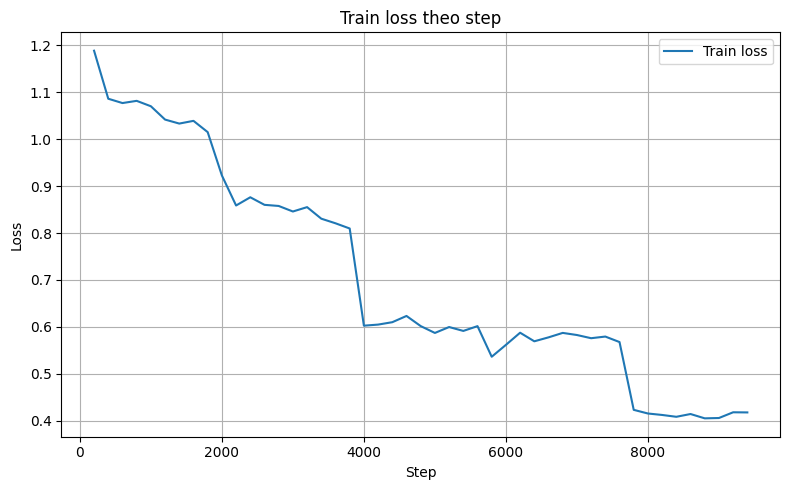

In [14]:
# Các bước có train loss
df_train = df_logs[df_logs["loss"].notna()][["step", "loss"]]

# # Các bước có eval loss
df_eval = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Đường train loss (dày hơn chút cho dễ nhìn)
plt.plot(df_train["step"], df_train["loss"], label="Train loss")


plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train loss theo step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


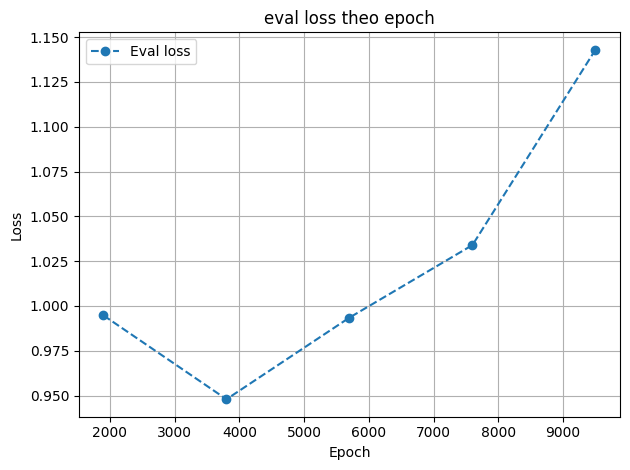

In [15]:
# # Các bước có eval loss
df_eval = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]]

plt.plot(df_eval["step"], df_eval["eval_loss"], marker="o", linestyle="--", label="Eval loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("eval loss theo epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Push best model into hugging face

In [16]:
print("Best checkpoint:", trainer.state.best_model_checkpoint)

Best checkpoint: /kaggle/working/qwen25-1_5b-vi-alpaca-small/checkpoint-3800


In [17]:
# take best model
best_dir = "/kaggle/working/qwen25-1_5b-vi-alpaca-small_augmented_data"

trainer.save_model(best_dir)        # lưu best model (weights + config)
tokenizer.save_pretrained(best_dir) # lưu tokenizer

print("Best model saved to:", best_dir)


Best model saved to: /kaggle/working/qwen25-1_5b-vi-alpaca-small_augmented_data


In [18]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_chatbot")

In [19]:
from huggingface_hub import login
login(token=secret_value_0)

In [20]:
repo_id = "lndat18/qwen25-1_5b-vi-alpaca-small_augmented_data"

# Load lại best model từ thư mục
model_to_push = AutoModelForCausalLM.from_pretrained(best_dir)
tokenizer_to_push = AutoTokenizer.from_pretrained(best_dir)

# Đẩy lên Hugging Face Hub
model_to_push.push_to_hub(repo_id)
tokenizer_to_push.push_to_hub(repo_id)

print("Pushed to HF repo:", repo_id)


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Pushed to HF repo: lndat18/qwen25-1_5b-vi-alpaca-small_augmented_data


# 7. Evaluate by Perplexity

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

import torch

In [5]:
# ================== 1. Load model + tokenizer ==================

base_model_id = "Qwen/Qwen2.5-1.5B-Instruct"
adapter_id    = "lndat18/qwen25-1_5b-vi-alpaca-small_augmented_data"

device = "cuda" if torch.cuda.is_available() else "cpu"

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    trust_remote_code=True,
)

model = PeftModel.from_pretrained(base_model, adapter_id)
model.eval()

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['alora_invocation_tokens', 'arrow_config', 'ensure_weight_tying', 'peft_version', 'target_parameters'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/73.9M [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1536)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1536, out_features=1536, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=1536, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(

In [8]:
ds = load_dataset("lndat18/vi-alpaca_small_augmented_data")["test"]

# Kiểm tra nhanh cấu trúc
print(ds[0]["messages"])

README.md:   0%|          | 0.00/611 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/6.81M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/847k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/857k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15200 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1900 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1900 [00:00<?, ? examples/s]

[{'content': 'Bạn là trợ lý AI hiểu tiếng Việt và trả lời ngắn gọn, rõ ràng.', 'role': 'system'}, {'content': '### HƯỚNG DẪN:\nHãy viết một câu chuyện ngắn từ các từ sau: "người đàn ông", "bước ra khỏi", "trong màn đêm", "vào công viên", "với một cuốn sách".\n\n### ĐẦU VÀO:\nNgười đàn ông bước ra khỏi căn nhà của mình trong màn đêm tối tăm. Anh ta đi bộ vào công viên với một cuốn sách trong tay.', 'role': 'user'}, {'content': 'Vào một đêm tối tăm, người đàn ông bước ra khỏi căn nhà của mình và đi bộ vào công viên. Anh ta cầm trên tay một cuốn sách, giữa không gian yên bình và đầy bí ẩn của đêm.', 'role': 'assistant'}]


In [9]:
def build_example(example, max_length=1024):
    """
    Từ 1 row dataset -> input_ids, labels, attention_mask
    - loss chỉ được tính trên token của câu trả lời (assistant)
    """
    messages = example["messages"]

    # Giả sử message cuối là assistant
    assert messages[-1]["role"] == "assistant"

    prompt_messages = messages[:-1]
    answer = messages[-1]["content"]

    # Build prompt (system + user), thêm generation prompt
    prompt_text = tokenizer.apply_chat_template(
        prompt_messages,
        tokenize=False,
        add_generation_prompt=True,
    )

    full_text = prompt_text + answer

    enc = tokenizer(
        full_text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    )

    input_ids = enc["input_ids"][0]
    attention_mask = enc["attention_mask"][0]

    # Xác định vị trí bắt đầu của câu trả lời (số token prompt)
    prompt_enc = tokenizer(
        prompt_text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    )
    prompt_len = prompt_enc["input_ids"].shape[1]

    # labels = input_ids, nhưng mask phần prompt bằng -100 (không tính loss)
    labels = input_ids.clone()
    labels[:prompt_len] = -100  # -100 = ignore_index trong CrossEntropyLoss

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }

In [10]:
# Áp dụng map để chuẩn bị dữ liệu
processed_ds = ds.map(build_example, remove_columns=ds.column_names)

# Chuyển sang torch format
processed_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

print(processed_ds[0])

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

{'input_ids': tensor([151644,   8948,    198,  94917,  37915, 128886, 128356,  15235, 129061,
        128607, 128324,  47742, 129477, 128814, 134780, 138345,     11, 129398,
        135111,     13, 151645,    198, 151644,    872,    198,  14374,    472,
        131099, 138862,   6140,    422, 144450,     45,    510,     39,   3202,
            88, 128839, 128249, 129260, 128963, 134780,  94576,  78228,  94576,
         32154,     25,    330,    968,  85532, 129560, 128436,    497,    330,
            65, 124603,  15122, 130553,    497,    330,    376,    644, 131718,
        131571,    497,    330,     85, 125017,  62029,  97483,    497,    330,
            85,  51947, 128249, 135570,  95082,  11436,  14374,  50327, 141468,
            52,    647,  71953,     46,    510,  20897,  85532, 129560, 128436,
        130203,  15122, 130553, 129209, 128275,  59735, 128312,  69086, 131718,
        131571, 129597,    259,  77354,     13,   1527,     71,   9450,  73586,
        128366,  86139,  6

In [11]:
batch_size = 4  # tùy VRAM, có thể tăng/giảm

def batch_iterator(dataset, batch_size):
    batch = {"input_ids": [], "attention_mask": [], "labels": []}
    for ex in dataset:
        for key in batch:
            batch[key].append(ex[key])
        if len(batch["input_ids"]) == batch_size:
            yield {k: torch.nn.utils.rnn.pad_sequence(v, batch_first=True, padding_value=tokenizer.pad_token_id if k!="labels" else -100)
                   for k, v in batch.items()}
            batch = {"input_ids": [], "attention_mask": [], "labels": []}
    # batch cuối
    if len(batch["input_ids"]) > 0:
        yield {k: torch.nn.utils.rnn.pad_sequence(v, batch_first=True, padding_value=tokenizer.pad_token_id if k!="labels" else -100)
               for k, v in batch.items()}

In [12]:
import math

In [15]:
# ================== 5. Tính perplexity ==================

total_nll = 0.0  # tổng negative log-likelihood
total_tokens = 0   # tổng số token có loss (labels != -100)

with torch.no_grad():
    for batch in tqdm(batch_iterator(processed_ds, batch_size), total=len(processed_ds)//batch_size + 1):
        batch = {k: v.to(model.device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )
        # outputs.loss là CE trung bình trên các token labels != -100 trong batch
        loss = outputs.loss

        # Số token thực sự được tính loss trong batch
        valid_tokens = (batch["labels"] != -100).sum().item()

        total_nll += loss.item() * valid_tokens
        total_tokens += valid_tokens

  0%|          | 0/476 [00:00<?, ?it/s]

In [16]:
avg_nll = total_nll / total_tokens
perplexity = math.exp(avg_nll)

print(f"Average NLL per token: {avg_nll:.4f}")
print(f"Perplexity: {perplexity:.4f}")

Average NLL per token: 1.2848
Perplexity: 3.6139
